<a href="https://colab.research.google.com/github/bye23mj/suanLee/blob/main/TF_6_3_%EC%BC%80%EB%9D%BC%EC%8A%A4_%EC%A0%84%EC%9D%B4_%ED%95%99%EC%8A%B5_(Transfer_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 케라스 전이 학습(Transfer Learning)

<img src="https://miro.medium.com/max/5252/1*Z11P-CjNYWBofEbmGQrptA.png">

<sub>출처: https://medium.com/the-official-integrate-ai-blog/transfer-learning-explained-7d275c1e34e2</sub>


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, AvgPool2D, Dropout, Input, BatchNormalization, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.applications import VGG16, MobileNet, ResNet50, Xception

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [ ]:
vgg16 = VGG16(weights='imagenet',
              input_shape=(32, 32, 3), include_top=False)

In [ ]:
model = Sequential()
model.add(vgg16)

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                        

In [ ]:
mobilenet = MobileNet(weights=None, input_shape=None, include_top=True)

resnet50 = ResNet50(weights=None, input_shape=None, include_top=True)

xception = Xception(weights=None, input_shape=None, include_top=True)

### 예제 : Dogs vs Cats
- Kaggle Data 이용: https://www.kaggle.com/c/dogs-vs-cats/data

- ImageDataGenerator의 flow_from_directory 이용

- 런타임 유형 GPU 사용

- 출처: https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb#scrollTo=SdW6geEVi2S8

#### modules import

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Input, Dropout, Dense, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

#### 데이터 로드

In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
  /content/cats_and_dogs_filtered.zip

--2022-07-08 00:08:19--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 108.177.120.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/content/cats_and_dogs_filtered.zip’

/content/cats_and_d 100%[===================>]  65.43M   110MB/s    in 0.6s    

2022-07-08 00:08:20 (110 MB/s) - ‘/content/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
local_zip = '/content/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
base_dir = '/content/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

#### 이미지 보강된 데이터 확인

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=40,
    zoom_range = 0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

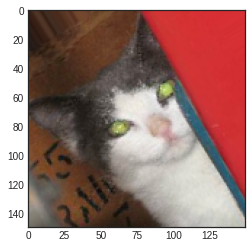

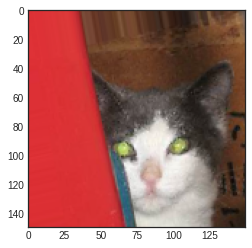

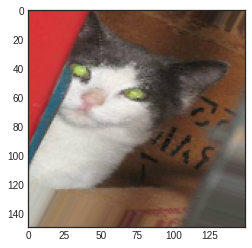

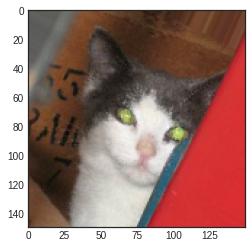

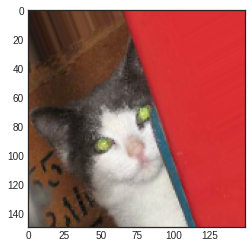

In [ ]:
img_path = os.path.join(train_cats_dir, train_cat_fnames[0])
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

i = 0

for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))
  i += 1
  if i % 5 == 0:
    break

#### 학습, 검증 데이터셋의 Data Generator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range = 0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 구성 및 컴파일

In [ ]:
with tpu_strategy.scope():
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150,150, 3)))
  model.add(MaxPool2D(2,2))
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPool2D(2,2))
  model.add(Conv2D(128, (3,3), activation='relu'))
  model.add(MaxPool2D(2,2))
  model.add(Conv2D(128, (3,3), activation='relu'))
  model.add(MaxPool2D(2,2))
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer=Adam(learning_rate=1e-4),
                metrics=['acc'])

  model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)     

#### 모델 학습 및 학습 과정 시각화
- 런타임유형 GPU 사용

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    batch_size=256,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=2)

Epoch 1/30


InternalError: ignored

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b--', label='Train Loss')
plt.plot(epochs, val_loss, 'b--', label='Validation Loss')
plt.grid()
plt.legend()

plt.plot(epochs, acc, 'b--', label='Train Accuracy')
plt.plot(epochs, val_acc, 'b--', label='Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

#### 모델 저장

In [ ]:
model.save("cats_and_dogs_model.h5")

### 사전 훈련된 모델 사용

In [ ]:
conv_base = VGG16(weights='imagenet',
                  inupt_shape=(150, 150, 3), include_top=False)

In [ ]:
def build_model_with_pretrained(conv_base):
  model = Sequential()
  model.add(conv_base)
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer=RMSport(learning_rate=2e-5),
                metrics=['accuracy'])
  
  return model

파라미터의 수 확인!

In [ ]:
model = build_model_with_pretrained(conv_base)
model.summary()

#### 레이어 동결
- 훈련하기 전, 합성곱 기반 레이어들의 가중치 학습을 막기 위해 이를 동결

In [ ]:
print(len(model.trainable_weights))

In [ ]:
conv_base.trainable = False
print(len(model.trainable_weights))

#### 모델 컴파일
- trainable 속성을 변경했기 때문에 다시 모델을 컴파일 해야함

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=2e-5),
              metrics=['accuracy'])

#### 이미지 제너레이터

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range = 0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

#### 모델 재학습

In [ ]:
history2 = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    batch_size=256,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=2)

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b--', label='Train Loss')
plt.plot(epochs, val_loss, 'b--', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label='Train Accuracy')
plt.plot(epochs, val_acc, 'b--', label='Validation Accuracy')
plt.grid()
plt.legend()

plt.show()

#### 모델 저장

In [ ]:
model.save('cats_end_dogs_with_pretrained_model.h5')

## Feature Map 시각화

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

### 모델 구성

In [ ]:
model = load_model('/content/cats_end_dogs_with_pretrained_model.h5')
model.summary()

In [ ]:
img_path = '/content/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = img_tensor[np.newaxis, ...]
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


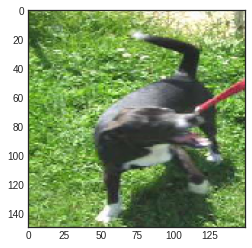

In [ ]:
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
conv_output = [layer.output for layer in model.layers[:8]]
conv_output

[<KerasTensor: shape=(None, 148, 148, 32) dtype=float32 (created by layer 'conv2d_4')>,
 <KerasTensor: shape=(None, 74, 74, 32) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 72, 72, 64) dtype=float32 (created by layer 'conv2d_5')>,
 <KerasTensor: shape=(None, 36, 36, 64) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 34, 34, 128) dtype=float32 (created by layer 'conv2d_6')>,
 <KerasTensor: shape=(None, 17, 17, 128) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <KerasTensor: shape=(None, 15, 15, 128) dtype=float32 (created by layer 'conv2d_7')>,
 <KerasTensor: shape=(None, 7, 7, 128) dtype=float32 (created by layer 'max_pooling2d_3')>]

In [ ]:
activation_model = Model(inputs=[model.input], outputs=conv_output)

In [ ]:
activations = activation_model.predict(img_tensor)

In [ ]:
len(activations)

8

### 시각화

(1, 148, 148, 32)


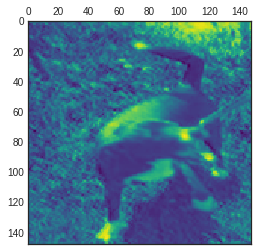

In [ ]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 4], cmap='viridis')
plt.show()

(1, 148, 148, 32)


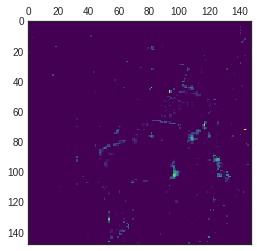

In [ ]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 20], cmap='viridis')
plt.show()

(1, 148, 148, 32)


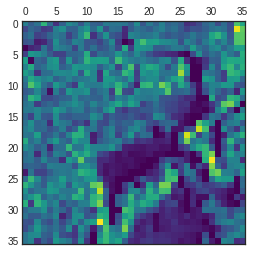

In [ ]:
print(activations[0].shape)
plt.matshow(activations[3][0, :, :, 1], cmap='viridis')
plt.show()

### 중간의 모든 활성화에 대해 시각화

In [ ]:
layer_names = []
for layer in model.layers[:8]:
  layer_names.append(layer.name)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
  num_features = layer_activation.shape[-1]

  size = layer_activation.shape[1]

  num_cols = num_features // images_per_row
  display_grid = np.zeros((size * num_cols, images_per_row + size))

  for col in range(num_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size: (col+1) * size, row * size : (row+1) * size] = channel_image
  
  scale = 1. / size

  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()  